#Import Library

In [99]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#Definisi Fungsi

In [100]:
# Fungsi Menampilkan Gambar
def show_image(title, image):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.axis('off')
    if len(image.shape) == 2:  # Grayscale
        plt.imshow(image, cmap='gray')
    else:  # Color
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [101]:
def show_images_grid(images_with_titles, cols=3, figsize=(15, 10)):
    """
    Menampilkan multiple gambar dalam grid layout

    Args:
        images_with_titles: List of tuples (title, image)
        cols: Jumlah kolom dalam grid
        figsize: Ukuran figure
    """
    n_images = len(images_with_titles)
    rows = (n_images + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Jika hanya ada satu baris, axes bukan array 2D
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    # Flatten axes untuk kemudahan iterasi
    axes_flat = axes.flatten()

    for i, (title, image) in enumerate(images_with_titles):
        ax = axes_flat[i]
        ax.set_title(title, fontsize=10, pad=10)
        ax.axis('off')

        if len(image.shape) == 2:  # Grayscale
            ax.imshow(image, cmap='gray')
        else:  # Color
            ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Sembunyikan subplot yang tidak digunakan
    for i in range(n_images, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.tight_layout()
    plt.show()

#Class Deteksi Warna

In [195]:
#Class untuk Deteksi warna Merah
class RedSignDetector:
    def __init__(self):
        # Rentang merah bawah (0–10)
        self.lower_red1 = np.array([0, 50, 50])
        self.upper_red1 = np.array([10, 255, 255])

        # Rentang merah atas (160–180)
        self.lower_red2 = np.array([160, 50, 50])
        self.upper_red2 = np.array([180, 255, 255])

        # Kernel morfologi
        self.kernel = np.ones((5, 5), np.uint8)

    def get_mask(self, hsv_image):
        """Menghasilkan mask merah dari gambar HSV."""
        mask1 = cv2.inRange(hsv_image, self.lower_red1, self.upper_red1)
        mask2 = cv2.inRange(hsv_image, self.lower_red2, self.upper_red2)
        combined_mask = cv2.bitwise_or(mask1, mask2)

        # Bersihkan mask dengan morfologi
        cleaned = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, self.kernel)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_DILATE, self.kernel)
        return cleaned

    def extract_red_sign(self, original_image):
        """Ambil bagian merah dari citra asli berdasarkan mask."""
        hsv = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
        mask = self.get_mask(hsv)
        red_part = cv2.bitwise_and(original_image, original_image, mask=mask)
        return red_part, mask

In [196]:
#Class untuk Deteksi warna Putih
class WhiteDetector:
    def __init__(self):
        # Rentang putih yang lebih luas dan fleksibel
        # Opsi 1: Rentang putih standar
        self.lower_white1 = np.array([0, 0, 180])    # Putih terang
        self.upper_white1 = np.array([180, 30, 255])

        # Opsi 2: Rentang abu-abu terang (untuk putih yang agak gelap)
        self.lower_white2 = np.array([0, 0, 90])    # Putih agak gelap
        self.upper_white2 = np.array([180, 60, 255])

        # Opsi 3: Rentang yang sangat luas untuk menangkap semua kemungkinan putih
        self.lower_white_broad = np.array([0, 0, 120])
        self.upper_white_broad = np.array([180, 70, 255])

        self.kernel = np.ones((3, 3), np.uint8)

    def get_white_mask_multiple_ranges(self, hsv_image):
        """Deteksi putih menggunakan beberapa rentang HSV."""
        # Mask untuk putih terang
        mask1 = cv2.inRange(hsv_image, self.lower_white1, self.upper_white1)

        # Mask untuk putih agak gelap
        mask2 = cv2.inRange(hsv_image, self.lower_white2, self.upper_white2)

        # Gabungkan kedua mask
        combined_mask = cv2.bitwise_or(mask1, mask2)

        # Bersihkan dengan morfologi
        cleaned = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, self.kernel)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, self.kernel)

        return cleaned

    def get_white_mask_broad(self, hsv_image):
        """Deteksi putih menggunakan rentang yang sangat luas."""
        mask = cv2.inRange(hsv_image, self.lower_white_broad, self.upper_white_broad)

        # Bersihkan dengan morfologi
        cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self.kernel)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, self.kernel)

        return cleaned

    def extract_white_adaptive(self, image):
        """Ekstrak putih menggunakan metode adaptif."""
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Coba beberapa metode
        mask_multiple = self.get_white_mask_multiple_ranges(hsv)
        mask_broad = self.get_white_mask_broad(hsv)

        # Gabungkan hasil untuk mendapatkan deteksi terbaik
        final_mask = cv2.bitwise_or(mask_multiple, mask_broad)

        return final_mask

In [197]:
#Class Deteksi warna putih yang ada didalam area rambu (warna merah)
class WhiteInsideRedDetector:
    def __init__(self):
        self.red_detector = RedSignDetector()
        self.white_detector = WhiteDetector()

    def extract_white_in_red_improved(self, image):
        """Ekstrak putih di dalam area merah dengan metode yang diperbaiki."""
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Dapatkan mask merah
        red_mask = self.red_detector.get_mask(hsv)

        # Dapatkan mask putih dengan metode yang diperbaiki
        white_mask = self.white_detector.extract_white_adaptive(image)

        # Metode 1: Ekspansi mask merah lebih besar untuk menangkap area sekitar
        kernel_expand_large = np.ones((15, 15), np.uint8)
        red_mask_expanded_large = cv2.morphologyEx(red_mask, cv2.MORPH_DILATE, kernel_expand_large)

        # Metode 2: Deteksi area rambu berdasarkan bentuk circular/elliptical
        red_area_enhanced = self.enhance_red_area_detection(red_mask, image)

        # Metode 3: Gabungkan area yang diperluas
        red_area_final = cv2.bitwise_or(red_mask_expanded_large, red_area_enhanced)

        # Ambil putih yang berada di area rambu yang diperluas
        white_in_red = cv2.bitwise_and(white_mask, red_area_final)

        # Metode 4: Jika masih kurang, ambil putih yang dekat dengan area merah
        white_near_red = self.get_white_near_red(white_mask, red_mask, image)

        # Gabungkan hasil
        white_final = cv2.bitwise_or(white_in_red, white_near_red)

        return white_final, white_mask, red_mask

    def enhance_red_area_detection(self, red_mask, image):
        """Enhance deteksi area merah berdasarkan bentuk dan konteks."""
        # Cari kontur dari mask merah
        contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        enhanced_mask = np.zeros_like(red_mask)

        for contour in contours:
            # Hanya proses kontur yang cukup besar (kemungkinan rambu)
            area = cv2.contourArea(contour)
            if area > 500:  # Threshold area minimum
                # Buat ellipse yang mencakup kontur
                if len(contour) >= 5:
                    ellipse = cv2.fitEllipse(contour)
                    cv2.ellipse(enhanced_mask, ellipse, 255, -1)
                else:
                    # Jika tidak bisa fit ellipse, gunakan bounding rect dengan padding
                    x, y, w, h = cv2.boundingRect(contour)
                    padding = 20
                    cv2.rectangle(enhanced_mask,
                                (max(0, x-padding), max(0, y-padding)),
                                (min(image.shape[1], x+w+padding), min(image.shape[0], y+h+padding)),
                                255, -1)

        return enhanced_mask

    def get_white_near_red(self, white_mask, red_mask, image):
        """Ambil area putih yang berada dekat dengan area merah."""
        # Perluas area merah dengan radius yang lebih besar
        kernel_large = np.ones((25, 25), np.uint8)
        red_expanded = cv2.morphologyEx(red_mask, cv2.MORPH_DILATE, kernel_large)

        # Ambil putih yang berada dalam area yang diperluas
        white_near = cv2.bitwise_and(white_mask, red_expanded)

        # Filter berdasarkan ukuran - buang area putih yang terlalu besar (kemungkinan background)
        contours, _ = cv2.findContours(white_near, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filtered_mask = np.zeros_like(white_near)

        for contour in contours:
            area = cv2.contourArea(contour)
            # Hanya ambil area putih yang tidak terlalu besar (kemungkinan bagian dari rambu)
            if 0 < area < 20 :  # Sesuaikan threshold sesuai kebutuhan
                cv2.fillPoly(filtered_mask, [contour], 255)

        return filtered_mask

#Fungsi Gaussian Kernel dan Konvolusi

In [198]:
# === Fungsi Gaussian kernel dan konvolusi manual ===
def create_gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

def manual_convolve_single_channel(image, kernel):
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    padded = cv2.copyMakeBorder(image, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_REFLECT)
    result = np.zeros_like(image, dtype=np.float32)

    for i in range(img_h):
        for j in range(img_w):
            region = padded[i:i + k_h, j:j + k_w]
            result[i, j] = np.sum(region * kernel)

    return np.clip(result, 0, 255).astype(np.uint8)

def manual_convolve(image, kernel):
    if len(image.shape) == 2:
        return manual_convolve_single_channel(image, kernel)
    else:
        channels = cv2.split(image)
        convolved = [manual_convolve_single_channel(c, kernel) for c in channels]
        return cv2.merge(convolved)

def manual_gaussian_blur(image, kernel_size=5, sigma=1):
    kernel = create_gaussian_kernel(kernel_size, sigma)
    return manual_convolve(image, kernel)

#Main Processing

In [214]:
# Load gambar (ganti path sesuai dengan lokasi file Anda)
image = cv2.imread('/content/larangan_parkir.jpg')
if image is None:
    print("Error: Tidak dapat membaca gambar. Periksa path file.")
    exit()
original = image.copy()

Debug HSV Values:
Point 1 (150,120): HSV=(113,48,239), RGB=(194,204,239)
Point 2 (160,130): HSV=(121,47,237), RGB=(194,193,237)
Point 3 (170,140): HSV=(5,62,255), RGB=(255,204,193)


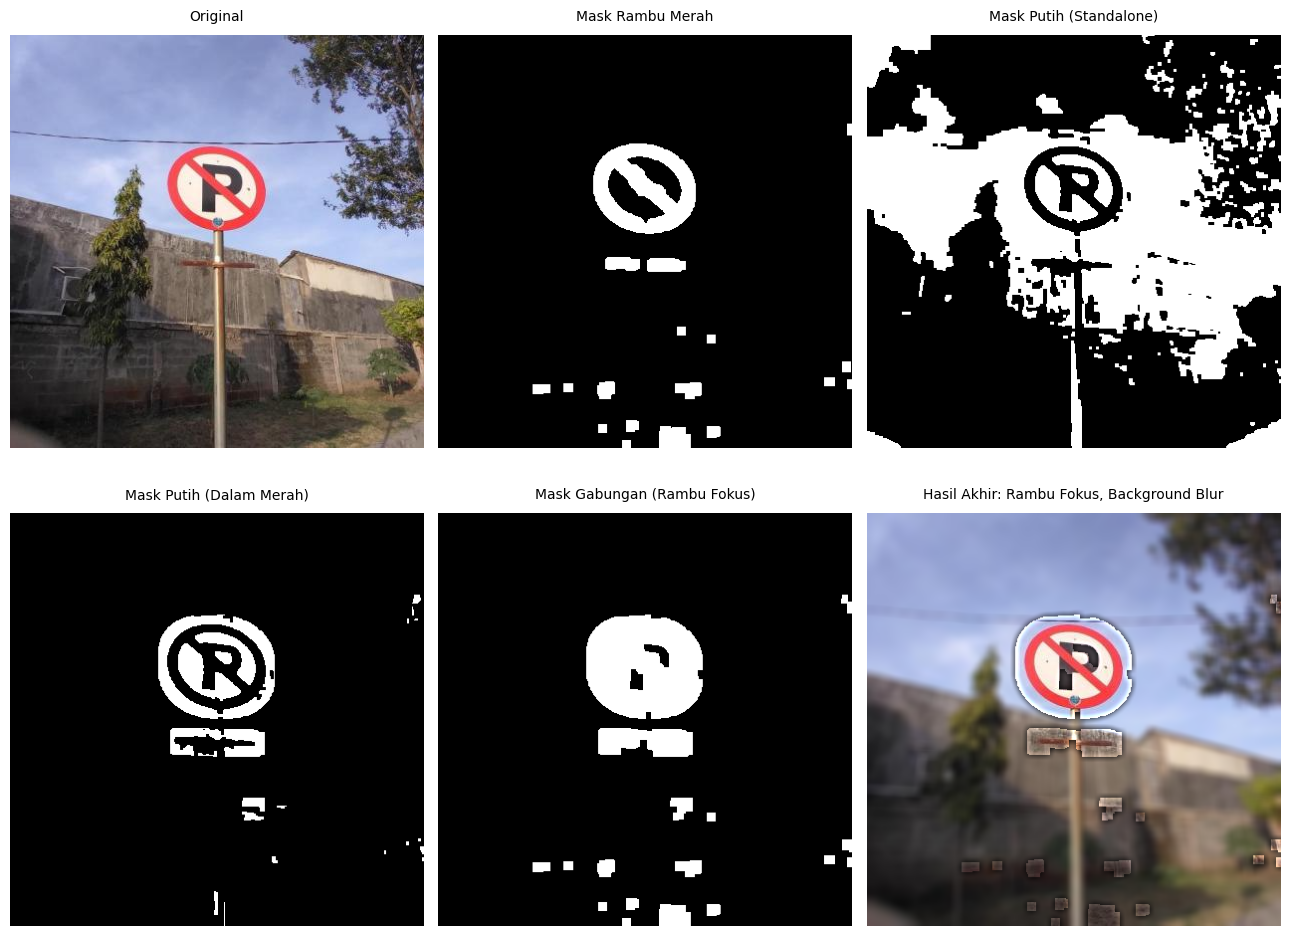

In [215]:
# Inisialisasi detector
red_detector = RedSignDetector()
white_in_red_detector = WhiteInsideRedDetector()
white_detector_standalone = WhiteDetector()

# Ekstrak mask merah
_, red_mask = red_detector.extract_red_sign(image)

# Ekstrak mask putih (beberapa versi untuk perbandingan)
white_mask_standalone = white_detector_standalone.extract_white_adaptive(image)
white_in_red_mask, white_mask_full, red_mask_debug = white_in_red_detector.extract_white_in_red_improved(image)

# Pilih mask putih yang terbaik (bisa disesuaikan)
white_mask_final = white_in_red_mask  # atau white_mask_standalone

# Gabungkan mask merah dan putih
mask_combined = cv2.bitwise_or(red_mask, white_mask_final)

# Bersihkan mask gabungan
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel)
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

# Buat mask background
mask_inv = cv2.bitwise_not(mask_cleaned)

# Proses segmentasi foreground dan background
fg_sharp = cv2.bitwise_and(original, original, mask=mask_cleaned)
bg_only = cv2.bitwise_and(original, original, mask=mask_inv)
bg_blurred = manual_gaussian_blur(bg_only, kernel_size=11, sigma=5)

# Gabungkan hasil akhir
final = cv2.add(bg_blurred, fg_sharp)

# Visualisasi hasil
images_to_show = [
    ("Original", original),
    ("Mask Rambu Merah", red_mask),
    ("Mask Putih (Standalone)", white_mask_standalone),
    ("Mask Putih (Dalam Merah)", white_in_red_mask),
    ("Mask Gabungan (Rambu Fokus)", mask_cleaned),
    ("Hasil Akhir: Rambu Fokus, Background Blur", final)
]

show_images_grid(images_to_show, cols=3, figsize=(13, 10))